In [1]:
import pandas as pd
import numpy as np
import datetime

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import colors


from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.decomposition import PCA

import warnings



In [2]:
data = pd.read_csv("./data/marketing_campaign.csv", sep='\t')

In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

There are some null value in income column. so, we have to remove this column.

In [5]:
data.dropna(inplace=True)

In [6]:
data.shape

(2216, 29)

I am creating a column name as `Customer_for`. which is num of days the customer started to the shop

In [7]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['Customer_for'] = data["Dt_Customer"].max() - data["Dt_Customer"]
data["Customer_for"] = data["Customer_for"].apply(lambda x: x.days)

C:\Users\MASUM\AppData\Local\Temp\ipykernel_12920\662215696.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])


**Now we will create few extra column to analyze the data more proferly:**
1. Age : it is extract from date_of_birth
2. Spent: Total Spending since two years in all categories
3. Living_with: is the person is living with partner or alone
4. children: number of children in the family
5. Family_size: number of family member in the family
6. Is_parent: is the buyer is parent or not.
7. education: I just modified the education into two features

In [8]:
data["Age"] = 2024 - data["Year_Birth"]
data["Spent"] = data["MntFishProducts"] + data["MntFruits"] + data["MntGoldProds"] + data["MntMeatProducts"] + data["MntSweetProducts"] + data["MntWines"]
data["Living_with"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Single": "Alone",  "Divorced": "Alone", "Absurd": "Alone", "YOLO": "Alone", "Widow": "Alone"})
data["Children"] = data["Kidhome"] + data["Teenhome"]
data["Family_size"] = data["Living_with"].replace({"Partner": 2, "Alone": 1}) + data["Children"]
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)


data["Education"] = data["Education"].replace({"Basic": "UnderGraduate", "2n Cycle": "UnderGraduate", "Graduation": "Graduate", "Master": "UnderGraduate", 'PhD': 'UnderGraduate'})


In [9]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_CostContact,Z_Revenue,Response,Customer_for,Age,Spent,Living_with,Children,Family_size,Is_Parent
0,5524,1957,Graduate,Single,58138.0,0,0,2012-04-09,58,635,...,3,11,1,971,67,1617,Alone,0,1,0
1,2174,1954,Graduate,Single,46344.0,1,1,2014-08-03,38,11,...,3,11,0,125,70,27,Alone,2,3,1
2,4141,1965,Graduate,Together,71613.0,0,0,2013-08-21,26,426,...,3,11,0,472,59,776,Partner,0,2,0
3,6182,1984,Graduate,Together,26646.0,1,0,2014-10-02,26,11,...,3,11,0,65,40,53,Partner,1,3,1
4,5324,1981,UnderGraduate,Married,58293.0,1,0,2014-01-19,94,173,...,3,11,0,321,43,422,Partner,1,3,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

**I am removing some unusual data.**

In [11]:
to_delete = ["Year_Birth", "ID", "Dt_Customer", "Z_Revenue", "Z_CostContact"]
data = data.drop(to_delete, axis=1)

### Data Engineering

In [12]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_for,Age,Spent,Children,Family_size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,512.006318,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,232.469034,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,340.000000,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,513.000000,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,686.000000,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1063.000000,131.000000,2525.000000,3.000000,5.000000,1.000000


There are few outliers in `Age` and `Income` column. There are some of the data is far away from others. if you broader look at the  graph, you will understand more clearly.

<Figure size 800x550 with 0 Axes>

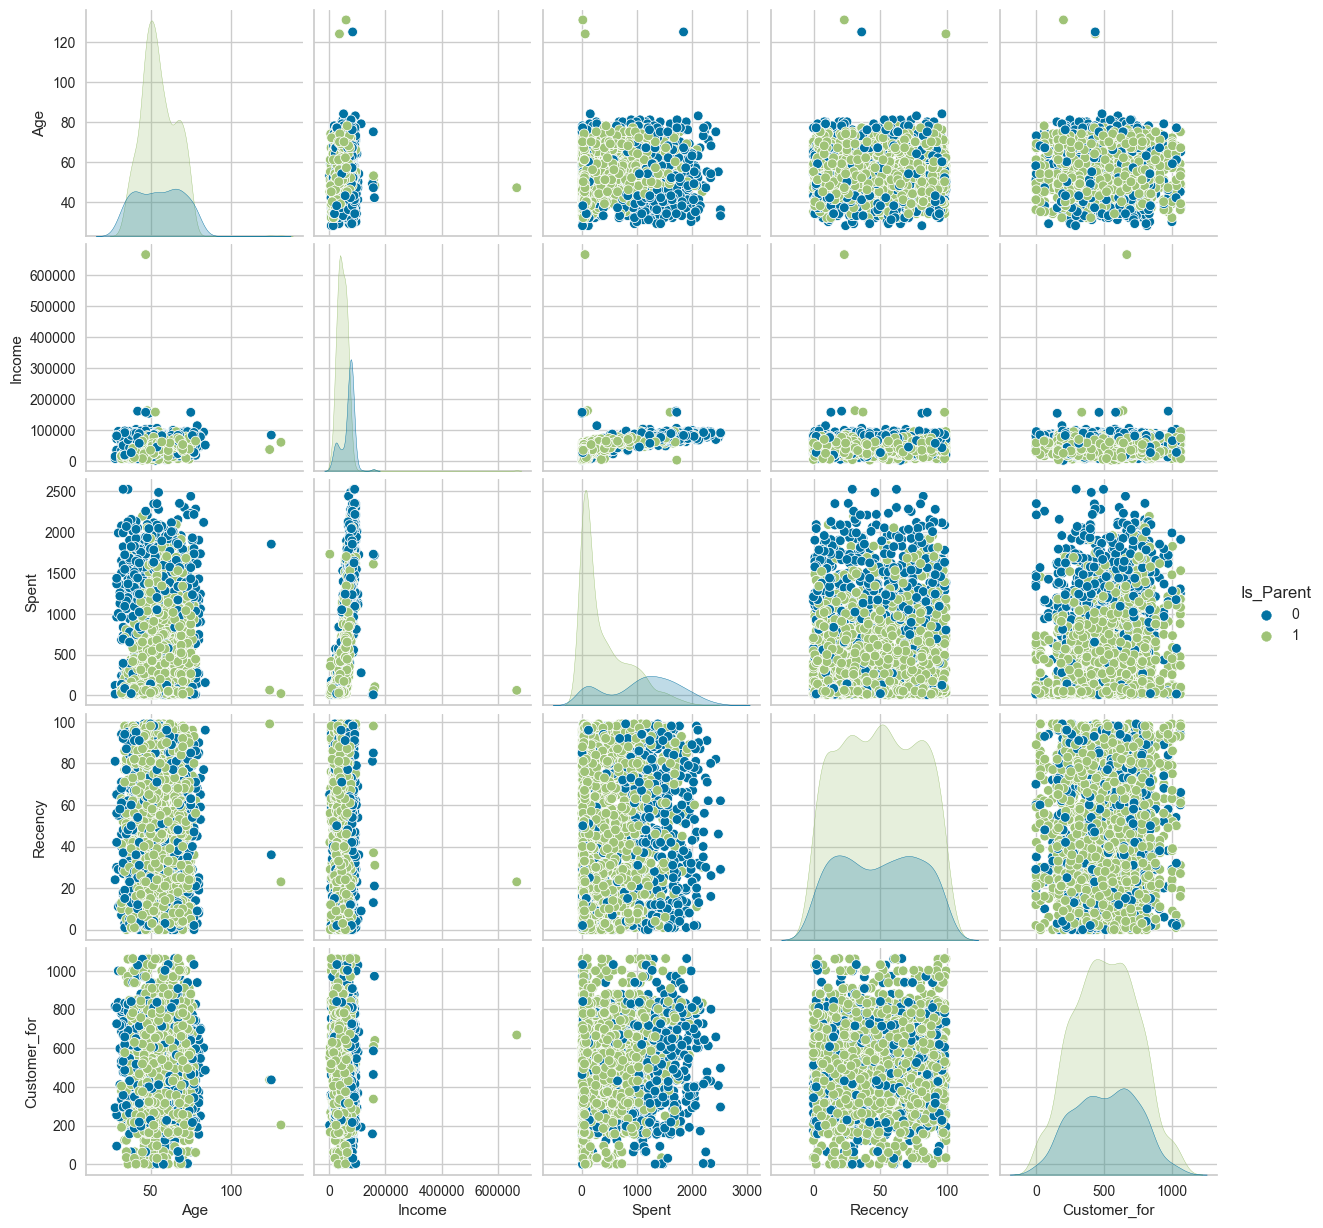

In [13]:
to_plot = ["Age", "Income", "Spent", "Is_Parent", "Recency", "Customer_for"]
plt.figure()
sns.pairplot(data[to_plot], hue='Is_Parent')

now we should drop these outliers of age and income

In [14]:
data = data[data["Age"]<90]
data = data[data["Income"]<600000]

print("After removing the data. the length of data: ",len(data))

After removing the data. the length of data:  2212


### Data Preprocessing

In [15]:
object_cols = list(data.dtypes[data.dtypes =="object"].index)
LE = LabelEncoder()
for col in object_cols:
    data[col] = data[[col]].apply(LE.fit_transform)

In [16]:
data[object_cols].head()

,Education,Marital_Status,Living_with
0,0,4,0
1,0,4,0
2,0,5,1
3,0,5,1
4,1,3,1


now we are scaling the data for better performance

In [17]:
scaler = StandardScaler()
scaled_data = data.copy()
scaler.fit(scaled_data)
scaled_data = pd.DataFrame(scaler.transform(scaled_data), columns=scaled_data.columns)

In [18]:
scaled_data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp2,Complain,Response,Customer_for,Age,Spent,Living_with,Children,Family_size,Is_Parent
0,-0.991895,0.254760,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,...,-0.117256,-0.09552,2.375425,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.991895,0.254760,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,...,-0.117256,-0.09552,-0.420977,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.991895,1.183144,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,...,-0.117256,-0.09552,-0.420977,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.991895,1.183144,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,...,-0.117256,-0.09552,-0.420977,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,1.008171,-0.673624,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,...,-0.117256,-0.09552,-0.420977,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [25]:
# now i need to drop more columns which doesn't need 
scaled_data = scaled_data.drop(["MntFishProducts", "MntFruits", "MntGoldProds","MntMeatProducts", "MntSweetProducts", "MntWines"], axis=1)

### Dimentionality Reduction

In [26]:
pca = PCA(n_components=3)
pca.fit(scaled_data)
pca_data = pd.DataFrame(pca.transform(scaled_data), columns= ["col1", "col2", "col3"])

In [27]:
pca_data.head()

,col1,col2,col3
0,3.393445,-0.192088,1.137489
1,-2.351827,-0.113317,-0.706931
2,2.372768,-0.385620,-1.368871
3,-2.108758,-1.745447,-0.158825
4,-0.880121,0.186953,-0.322207


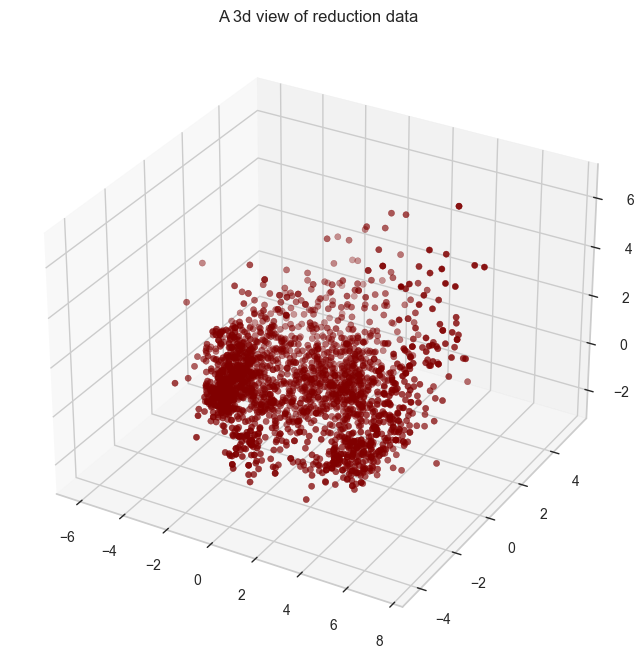

In [28]:
plt.figure(figsize=(12,8))
fig = plt.subplot(111, projection="3d")
fig.scatter(pca_data["col1"], pca_data["col2"],pca_data["col3"], c="maroon")
fig.set_title("A 3d view of reduction data")
plt.show()

**Before Dive into clustering algorithm. first we need to find the how accurate number of clusters. we can find it by `KElbowMethod` and `silhouette score`.**

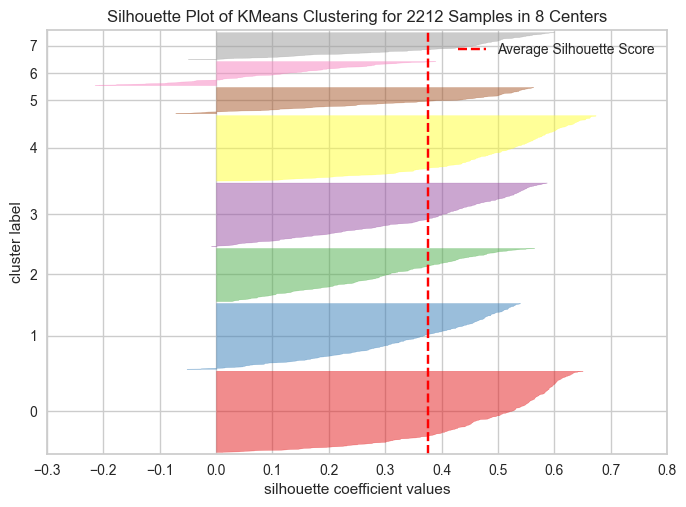

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 2212 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
silhaut = SilhouetteVisualizer(KMeans(), k=10)
silhaut.fit(pca_data)
silhaut.show()

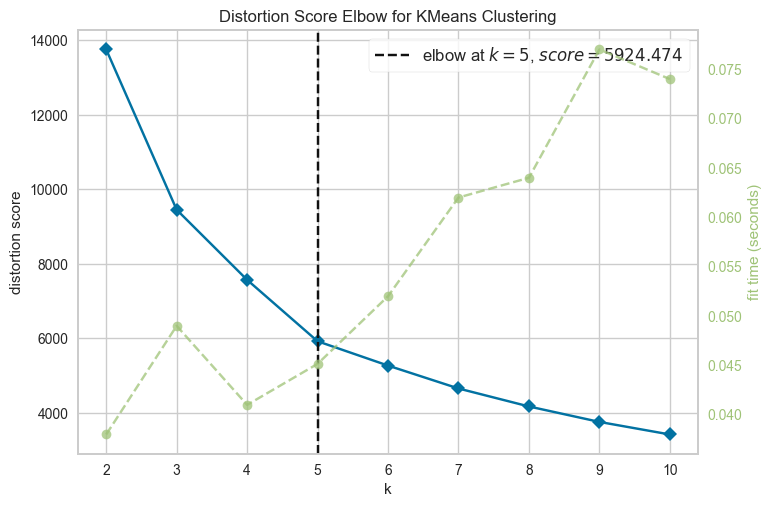

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
kelbow = KElbowVisualizer(KMeans(), k=10)
kelbow.fit(pca_data)
kelbow.show()